### Discord Exfiltration - Anomaly Detection

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, davies_bouldin_score
import sklearn.decomposition as skd
from scipy.stats import lognorm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import seaborn as sns

#### Dataset import and cleaning

In [12]:
# Read the CSV file (remove the index column)
discord_normal_observation_dataset = pd.read_csv('features/alex_sample2_features_m3_w[300]_s30.csv', delimiter=',')

# Display the first few rows of the dataframe
print("Big Normal Shape: ",discord_normal_observation_dataset.shape)
discord_normal_observation_dataset.head()

Big Normal Shape:  (1207, 22)


,mean_silence_duration,variance_silence_duration,mean_activity_duration,variance_activity_duration,60_percentile_activity_duration,90_percentile_activity_duration,tcp_upload_bytes_std_dev,tcp_download_bytes_std_dev,udp_upload_bytes_std_dev,udp_download_bytes_std_dev,...,udp_upload_bytes_mean,udp_download_bytes_mean,95_percentile_upload_bytes,98_percentile_upload_bytes,95_percentile_download_bytes,98_percentile_download_bytes,bytes_mean,bytes_std_dev,packets_mean,packets_std_dev
0,8.258,66.450,1.419,0.631,1.0,3.0,123.963,676.990,2305.174,27513.067,...,470.280,2024.587,2686.65,7452.08,979.85,3755.04,2615.150,28680.764,3.880,29.391
1,10.680,78.138,1.375,0.651,1.0,2.7,123.314,677.065,2040.466,27457.893,...,311.480,1830.363,200.50,4722.90,654.70,2588.92,2261.493,28557.129,3.237,29.007
2,10.920,82.714,1.125,0.193,1.0,1.0,121.537,673.114,1046.289,868.867,...,116.197,79.370,120.55,1385.36,416.45,701.62,307.027,2503.127,1.003,4.394
3,11.500,77.667,1.043,0.042,1.0,1.0,40.085,103.280,643.053,390.804,...,68.237,34.377,92.45,132.58,266.10,552.72,147.790,1067.640,0.693,2.708
4,12.043,122.737,1.045,0.043,1.0,1.0,39.886,97.910,643.053,390.804,...,68.237,34.377,91.00,132.58,248.15,552.72,145.800,1067.135,0.683,2.685


In [13]:
discord_small_normal_observation_dataset = pd.read_csv('features/alex_sample_features_m3_w[300]_s30.csv', delimiter=',')

print("Small Normal Shape: ",discord_small_normal_observation_dataset.shape)
discord_small_normal_observation_dataset.head()

Small Normal Shape:  (510, 22)


,mean_silence_duration,variance_silence_duration,mean_activity_duration,variance_activity_duration,60_percentile_activity_duration,90_percentile_activity_duration,tcp_upload_bytes_std_dev,tcp_download_bytes_std_dev,udp_upload_bytes_std_dev,udp_download_bytes_std_dev,...,udp_upload_bytes_mean,udp_download_bytes_mean,95_percentile_upload_bytes,98_percentile_upload_bytes,95_percentile_download_bytes,98_percentile_download_bytes,bytes_mean,bytes_std_dev,packets_mean,packets_std_dev
0,9.214,102.740,1.500,0.821,1.0,2.3,57.244,140.173,1935.232,95954.571,...,306.107,6954.563,921.60,3239.04,859.40,9706.62,7332.110,97236.783,7.913,89.738
1,8.467,95.582,1.586,1.001,1.0,3.0,58.611,152.980,2234.770,95952.288,...,436.623,6992.230,2179.20,7357.46,1271.75,9706.62,7508.877,97234.209,8.337,89.752
2,7.844,93.319,1.581,0.953,1.0,3.0,59.766,148.388,2248.605,95951.572,...,464.500,7002.963,2259.80,7357.46,1590.40,9706.62,7547.907,97232.045,8.417,89.748
3,6.861,79.120,1.514,0.878,1.0,2.6,72.385,152.524,2255.933,95951.198,...,482.800,7008.413,2696.75,7357.46,1590.40,9706.62,7580.517,97230.125,8.513,89.742
4,6.944,77.164,1.429,0.816,1.0,2.0,57.021,155.762,2240.729,95952.112,...,451.647,6994.777,2185.70,7357.46,1190.05,9706.62,7534.003,97232.741,8.400,89.745


In [14]:
discord_malicious_observation_dataset = pd.read_csv('features/alex_sample3_features_m3_w[300]_s30.csv', delimiter=',')

print("Malicious Shape: ",discord_malicious_observation_dataset.shape)
discord_malicious_observation_dataset.head()

Malicious Shape:  (596, 22)


,mean_silence_duration,variance_silence_duration,mean_activity_duration,variance_activity_duration,60_percentile_activity_duration,90_percentile_activity_duration,tcp_upload_bytes_std_dev,tcp_download_bytes_std_dev,udp_upload_bytes_std_dev,udp_download_bytes_std_dev,...,udp_upload_bytes_mean,udp_download_bytes_mean,95_percentile_upload_bytes,98_percentile_upload_bytes,95_percentile_download_bytes,98_percentile_download_bytes,bytes_mean,bytes_std_dev,packets_mean,packets_std_dev
0,10.750,181.854,1.750,2.021,1.0,3.0,502.234,1666.098,2734.795,59512.528,...,532.823,4650.107,2802.95,7779.44,1786.3,16859.98,5413.117,61592.687,6.617,60.384
1,8.643,129.658,2.071,4.138,1.2,3.9,779.688,2472.858,2736.827,59527.498,...,544.167,4764.583,3774.20,7779.44,9972.6,18479.86,5927.227,61627.144,7.683,60.528
2,6.875,116.859,2.581,11.663,2.0,6.0,735078.500,62105.393,2789.125,68120.335,...,579.703,6698.053,6170.65,586955.56,17689.9,39229.80,107350.690,766860.572,31.907,186.307
3,6.938,117.871,2.438,10.871,2.0,3.0,735071.486,64534.700,2866.024,113162.036,...,528.697,11728.603,7914.55,586955.56,17777.2,208368.04,113432.697,771679.071,37.607,204.615
4,5.889,89.432,2.444,9.969,2.0,4.0,735064.515,64531.830,2864.698,113162.510,...,521.617,11723.727,7914.55,586955.56,17777.2,208368.04,113505.200,771668.678,37.960,204.563


In [15]:
print("Normal Big Capture Before Cleaning: ",discord_normal_observation_dataset.shape)
print("Normal Small Capture Before Cleaning: ",discord_small_normal_observation_dataset.shape)
print("Malicious Capture Before Cleaning: ",discord_malicious_observation_dataset.shape)

# Remove all the rows with 'mean_activity_duration' == 0
discord_normal_observation_dataset = discord_normal_observation_dataset[discord_normal_observation_dataset['mean_activity_duration'] != 0]
discord_small_normal_observation_dataset = discord_small_normal_observation_dataset[discord_small_normal_observation_dataset['mean_activity_duration'] != 0]
discord_malicious_observation_dataset = discord_malicious_observation_dataset[discord_malicious_observation_dataset['mean_activity_duration'] != 0]

print("\n\nNormal Big Capture After Cleaning", discord_normal_observation_dataset.shape)
print("Normal Small Capture After Cleaning", discord_small_normal_observation_dataset.shape)
print("Malicious Capture After Cleaning", discord_malicious_observation_dataset.shape)

Normal Big Capture Before Cleaning:  (1207, 22)
Normal Small Capture Before Cleaning:  (510, 22)
Malicious Capture Before Cleaning:  (596, 22)


Normal Big Capture After Cleaning (1207, 22)
Normal Small Capture After Cleaning (510, 22)
Malicious Capture After Cleaning (596, 22)


#### Dataset Analysis

##### Distribution of the Mean Silence Duration

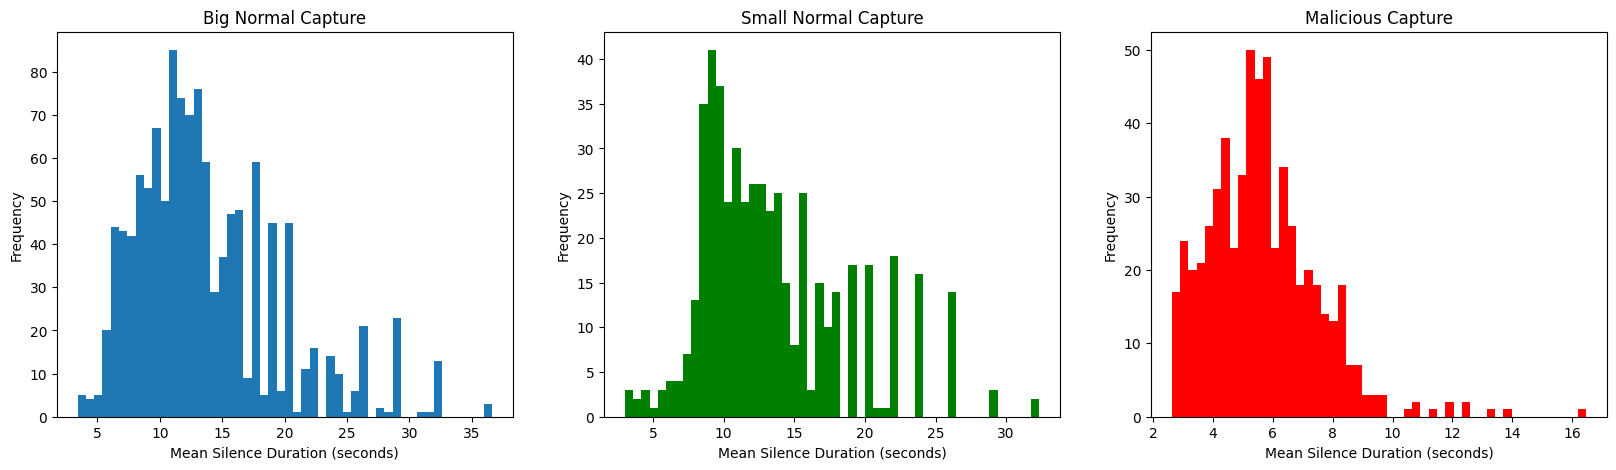

In [86]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(discord_normal_observation_dataset['mean_silence_duration'], bins=50)
plt.title('Big Normal Capture')
plt.xlabel('Mean Silence Duration (seconds)')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(discord_small_normal_observation_dataset['mean_silence_duration'], bins=50, color='green')
plt.title('Small Normal Capture')
plt.xlabel('Mean Silence Duration (seconds)')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(discord_malicious_observation_dataset['mean_silence_duration'], bins=50, color='red')
plt.title('Malicious Capture')
plt.xlabel('Mean Silence Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

##### Distribution of the Mean Activity Duration

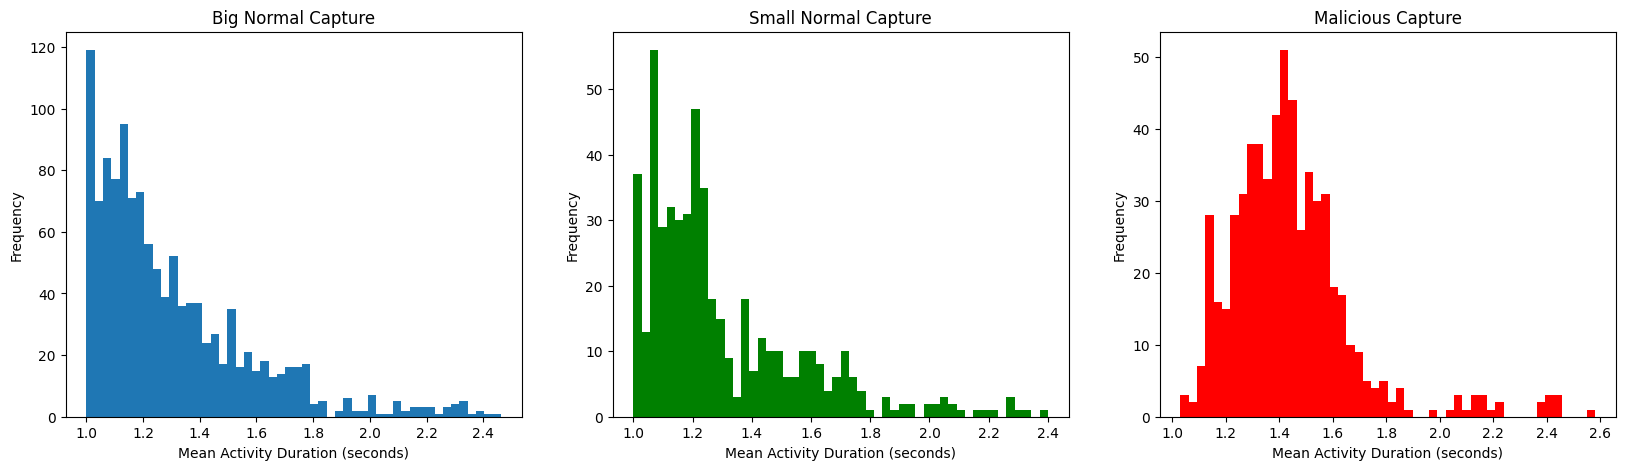

In [87]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(discord_normal_observation_dataset['mean_activity_duration'], bins=50)
plt.title('Big Normal Capture')
plt.xlabel('Mean Activity Duration (seconds)')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(discord_small_normal_observation_dataset['mean_activity_duration'], bins=50, color='green')
plt.title('Small Normal Capture')
plt.xlabel('Mean Activity Duration (seconds)')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(discord_malicious_observation_dataset['mean_activity_duration'], bins=50, color='red')
plt.title('Malicious Capture')
plt.xlabel('Mean Activity Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

##### Upload/Download Ratio Scatter

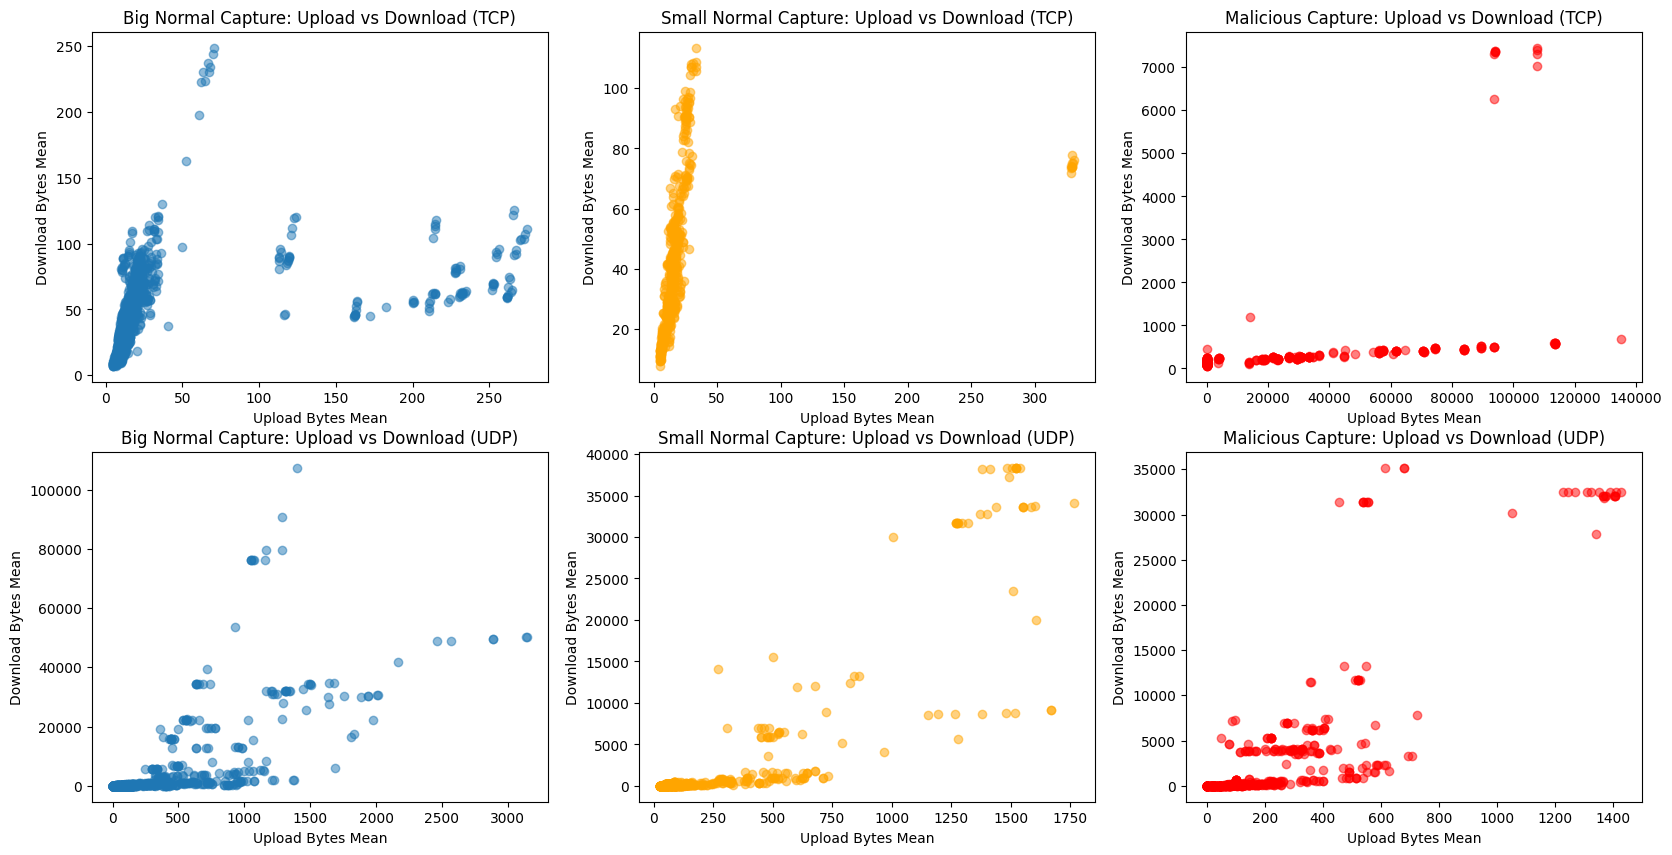

In [18]:
plt.figure(figsize=(20, 10))

# Scatter Plot for Upload vs Download
plt.subplot(2, 3, 1)
plt.scatter(discord_normal_observation_dataset['tcp_upload_bytes_mean'],
            discord_normal_observation_dataset['tcp_download_bytes_mean'], alpha=0.5)
plt.title('Big Normal Capture: Upload vs Download (TCP)')
plt.xlabel('Upload Bytes Mean')
plt.ylabel('Download Bytes Mean')

plt.subplot(2, 3, 2)
plt.scatter(discord_small_normal_observation_dataset['tcp_upload_bytes_mean'],
            discord_small_normal_observation_dataset['tcp_download_bytes_mean'], alpha=0.5, color='orange')
plt.title('Small Normal Capture: Upload vs Download (TCP)')
plt.xlabel('Upload Bytes Mean')
plt.ylabel('Download Bytes Mean')

plt.subplot(2, 3, 3)
plt.scatter(discord_malicious_observation_dataset['tcp_upload_bytes_mean'],
            discord_malicious_observation_dataset['tcp_download_bytes_mean'], alpha=0.5, color='red')
plt.title('Malicious Capture: Upload vs Download (TCP)')
plt.xlabel('Upload Bytes Mean')
plt.ylabel('Download Bytes Mean')

# The same for UDP

plt.subplot(2, 3, 4)
plt.scatter(discord_normal_observation_dataset['udp_upload_bytes_mean'],
            discord_normal_observation_dataset['udp_download_bytes_mean'], alpha=0.5)
plt.title('Big Normal Capture: Upload vs Download (UDP)')
plt.xlabel('Upload Bytes Mean')
plt.ylabel('Download Bytes Mean')

plt.subplot(2, 3, 5)
plt.scatter(discord_small_normal_observation_dataset['udp_upload_bytes_mean'],
            discord_small_normal_observation_dataset['udp_download_bytes_mean'], alpha=0.5, color='orange')
plt.title('Small Normal Capture: Upload vs Download (UDP)')
plt.xlabel('Upload Bytes Mean')
plt.ylabel('Download Bytes Mean')

plt.subplot(2, 3, 6)
plt.scatter(discord_malicious_observation_dataset['udp_upload_bytes_mean'],
            discord_malicious_observation_dataset['udp_download_bytes_mean'], alpha=0.5, color='red')
plt.title('Malicious Capture: Upload vs Download (UDP)')
plt.xlabel('Upload Bytes Mean')
plt.ylabel('Download Bytes Mean')

plt.show()

##### Upload/Download Histogram

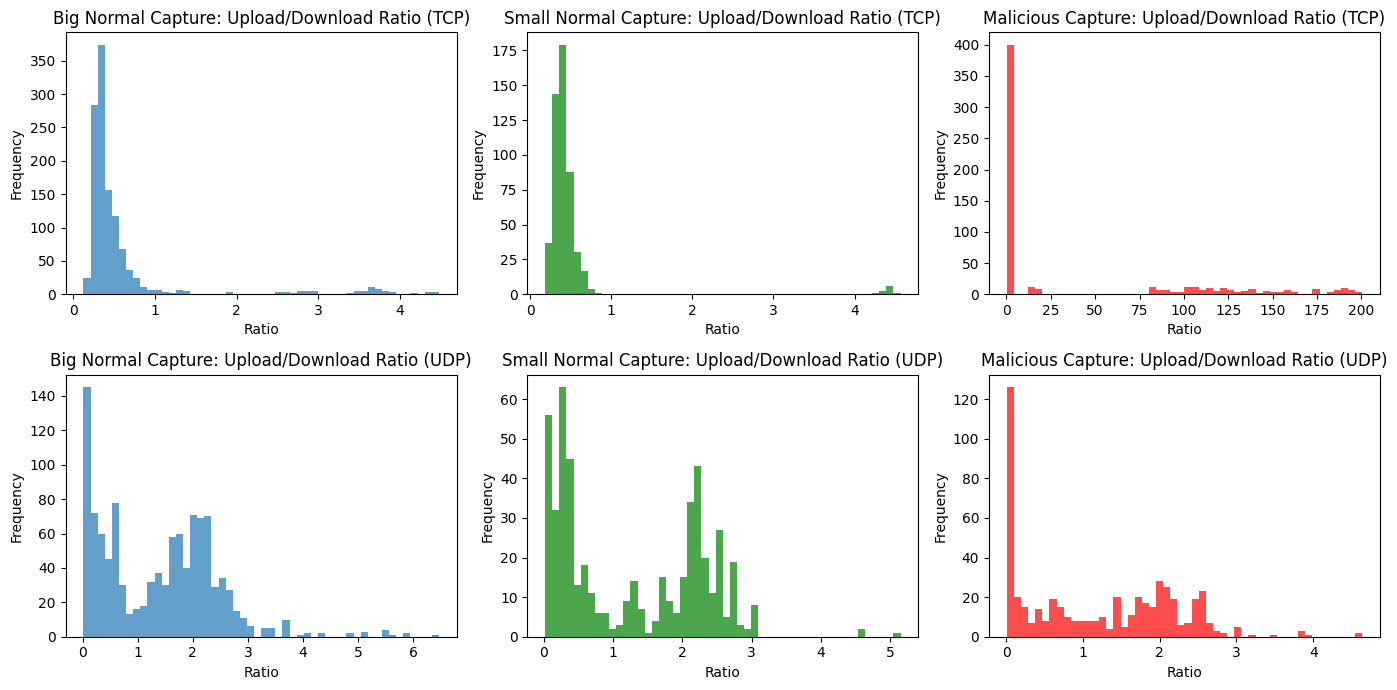

In [19]:
# Calculate upload/download ratios temporarily
normal_ratios_tcp = (discord_normal_observation_dataset['tcp_upload_bytes_mean'] / discord_normal_observation_dataset['tcp_download_bytes_mean'])
small_normal_ratios_tcp = (discord_small_normal_observation_dataset['tcp_upload_bytes_mean'] / discord_small_normal_observation_dataset['tcp_download_bytes_mean'])
malicious_ratios_tcp = (discord_malicious_observation_dataset['tcp_upload_bytes_mean'] / discord_malicious_observation_dataset['tcp_download_bytes_mean'])

normal_ratios_udp = (discord_normal_observation_dataset['udp_upload_bytes_mean'] / discord_normal_observation_dataset['udp_download_bytes_mean'])
small_normal_ratios_udp = (discord_small_normal_observation_dataset['udp_upload_bytes_mean'] / discord_small_normal_observation_dataset['udp_download_bytes_mean'])
malicious_ratios_udp = (discord_malicious_observation_dataset['udp_upload_bytes_mean'] / discord_malicious_observation_dataset['udp_download_bytes_mean'])

plt.figure(figsize=(14, 7))

# Ratio Histograms
plt.subplot(2, 3, 1)
plt.hist(normal_ratios_tcp, bins=50, alpha=0.7)
plt.title('Big Normal Capture: Upload/Download Ratio (TCP)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.hist(small_normal_ratios_tcp, bins=50, alpha=0.7, color='green')
plt.title('Small Normal Capture: Upload/Download Ratio (TCP)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
plt.hist(malicious_ratios_tcp, bins=50, alpha=0.7, color='red')
plt.title('Malicious Capture: Upload/Download Ratio (TCP)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.subplot(2, 3, 4)
plt.hist(normal_ratios_udp, bins=50, alpha=0.7)
plt.title('Big Normal Capture: Upload/Download Ratio (UDP)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
plt.hist(small_normal_ratios_udp, bins=50, alpha=0.7, color='green')
plt.title('Small Normal Capture: Upload/Download Ratio (UDP)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.subplot(2, 3, 6)
plt.hist(malicious_ratios_udp, bins=50, alpha=0.7, color='red')
plt.title('Malicious Capture: Upload/Download Ratio (UDP)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Standard Deviation Bell Graph

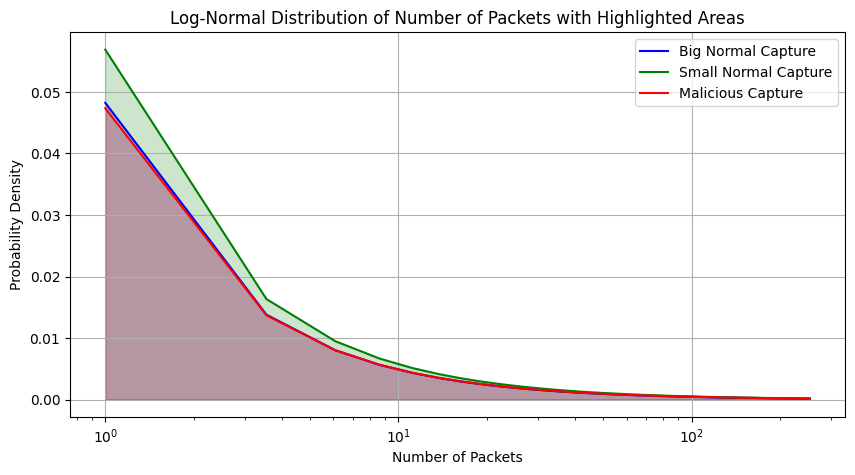

In [20]:
normal_std_dev = discord_normal_observation_dataset['packets_std_dev'].mean()
small_normal_std_dev = discord_small_normal_observation_dataset['packets_std_dev'].mean()
malicious_std_dev = discord_malicious_observation_dataset['packets_std_dev'].mean()

normal_mean = discord_normal_observation_dataset['packets_mean'].mean()
small_normal_mean = discord_small_normal_observation_dataset['packets_mean'].mean()
malicious_mean = discord_malicious_observation_dataset['packets_mean'].mean()

# Generate x-axis dynamically based on byte range
x_min = 1  # Start from 1 since log-normal requires positive values
x_max = max(normal_mean + 4 * normal_std_dev,
            small_normal_mean + 4 * small_normal_std_dev,
            malicious_mean + 4 * malicious_std_dev)
x = np.linspace(x_min, x_max, 100)

# Log-normal PDFs
shape_normal = normal_std_dev / normal_mean
scale_normal = normal_mean
normal_pdf = lognorm.pdf(x, s=shape_normal, scale=scale_normal)

shape_small = small_normal_std_dev / small_normal_mean
scale_small = small_normal_mean
small_normal_pdf = lognorm.pdf(x, s=shape_small, scale=scale_small)

shape_malicious = malicious_std_dev / malicious_mean
scale_malicious = malicious_mean
malicious_pdf = lognorm.pdf(x, s=shape_malicious, scale=scale_malicious)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x, normal_pdf, label='Big Normal Capture', color='blue')
plt.plot(x, small_normal_pdf, label='Small Normal Capture', color='green')
plt.plot(x, malicious_pdf, label='Malicious Capture', color='red')

# Highlight Areas Under Curve
plt.fill_between(x, normal_pdf, alpha=0.2, color='blue')
plt.fill_between(x, small_normal_pdf, alpha=0.2, color='green')
plt.fill_between(x, malicious_pdf, alpha=0.2, color='red')

# Add titles and labels
plt.title('Log-Normal Distribution of Number of Packets with Highlighted Areas')
plt.xlabel('Number of Packets')
plt.ylabel('Probability Density')
plt.xscale('log')  # Apply log scale on X-axis
plt.legend()
plt.grid(True)

plt.show()

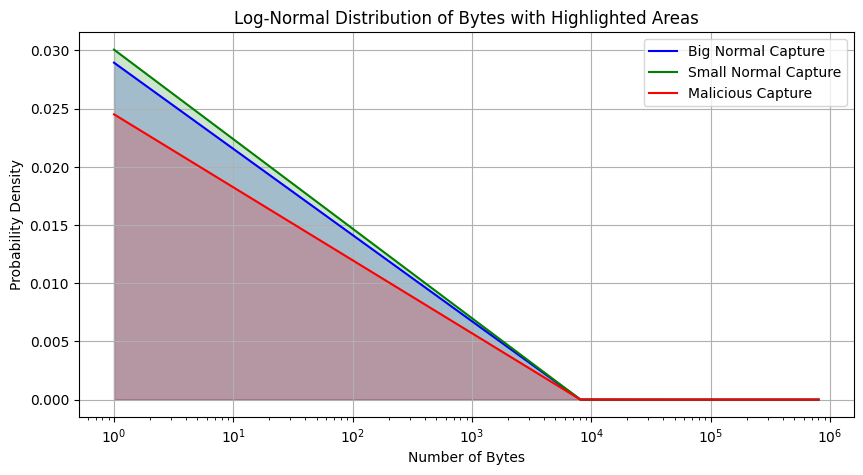

In [21]:
normal_std_dev = discord_normal_observation_dataset['bytes_std_dev'].mean()
small_normal_std_dev = discord_small_normal_observation_dataset['bytes_std_dev'].mean()
malicious_std_dev = discord_malicious_observation_dataset['bytes_std_dev'].mean()

normal_mean = discord_normal_observation_dataset['bytes_mean'].mean()
small_normal_mean = discord_small_normal_observation_dataset['bytes_mean'].mean()
malicious_mean = discord_malicious_observation_dataset['bytes_mean'].mean()

# Generate x-axis dynamically based on byte range
x_min = 1  # Start from 1 since log-normal requires positive values
x_max = max(normal_mean + 4 * normal_std_dev,
            small_normal_mean + 4 * small_normal_std_dev,
            malicious_mean + 4 * malicious_std_dev)
x = np.linspace(x_min, x_max, 100)

# Log-normal PDFs
shape_normal = normal_std_dev / normal_mean
scale_normal = normal_mean
normal_pdf = lognorm.pdf(x, s=shape_normal, scale=scale_normal)

shape_small = small_normal_std_dev / small_normal_mean
scale_small = small_normal_mean
small_normal_pdf = lognorm.pdf(x, s=shape_small, scale=scale_small)

shape_malicious = malicious_std_dev / malicious_mean
scale_malicious = malicious_mean
malicious_pdf = lognorm.pdf(x, s=shape_malicious, scale=scale_malicious)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x, normal_pdf, label='Big Normal Capture', color='blue')
plt.plot(x, small_normal_pdf, label='Small Normal Capture', color='green')
plt.plot(x, malicious_pdf, label='Malicious Capture', color='red')

# Highlight Areas Under Curve
plt.fill_between(x, normal_pdf, alpha=0.2, color='blue')
plt.fill_between(x, small_normal_pdf, alpha=0.2, color='green')
plt.fill_between(x, malicious_pdf, alpha=0.2, color='red')

# Add titles and labels
plt.title('Log-Normal Distribution of Bytes with Highlighted Areas')
plt.xlabel('Number of Bytes')
plt.ylabel('Probability Density')
plt.xscale('log')  # Apply log scale on X-axis
plt.legend()
plt.grid(True)

plt.show()

##### Standard Deviation Distribution

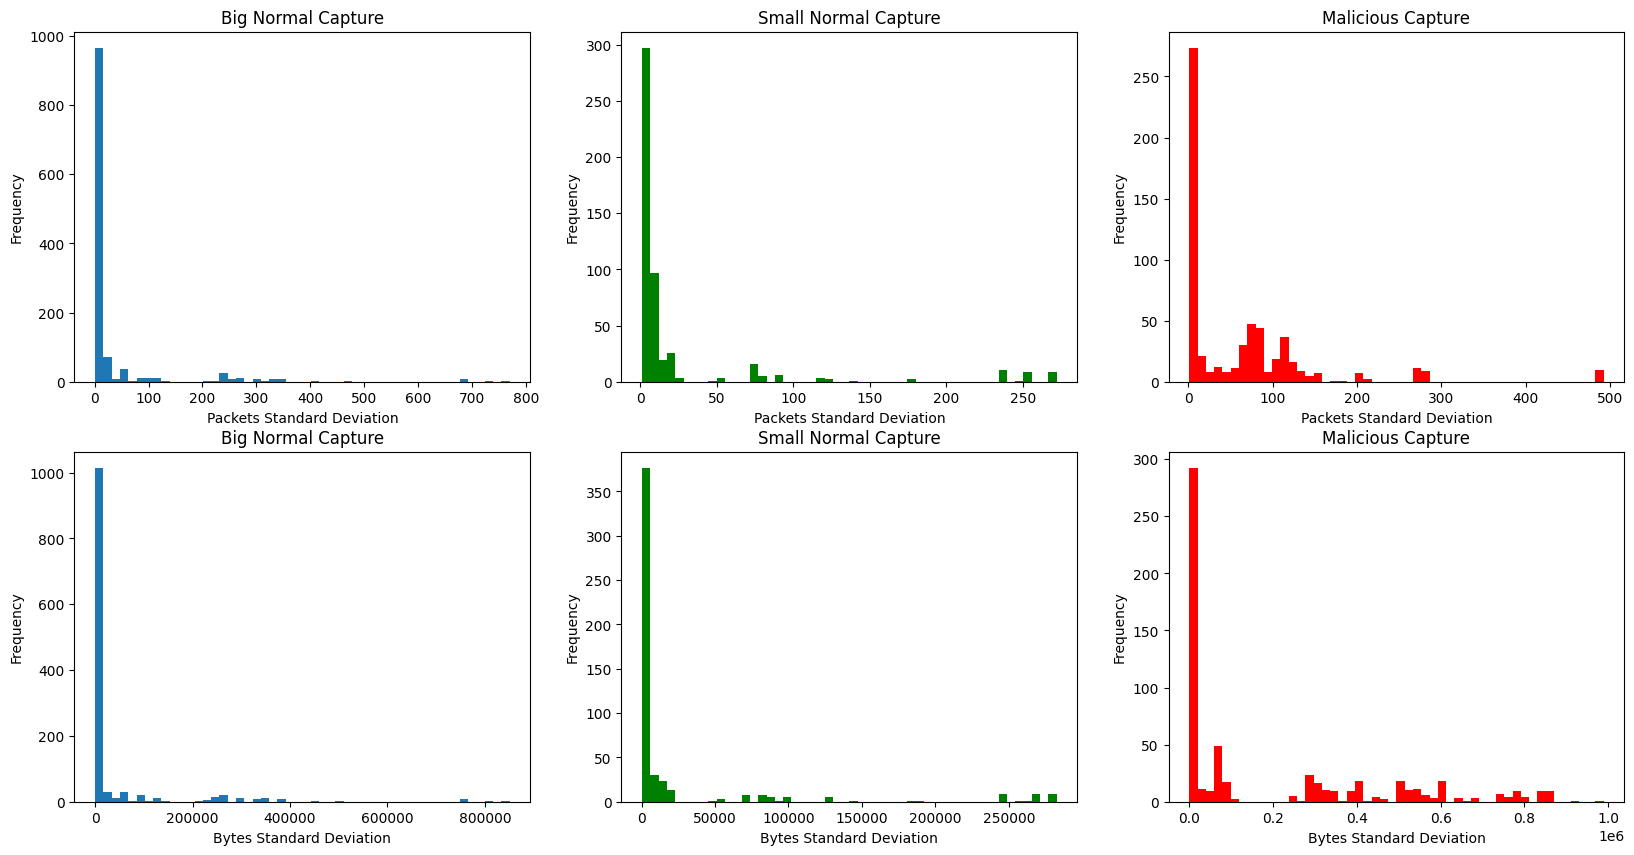

In [22]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.hist(discord_normal_observation_dataset['packets_std_dev'], bins=50)
plt.title('Big Normal Capture')
plt.xlabel('Packets Standard Deviation')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.hist(discord_small_normal_observation_dataset['packets_std_dev'], bins=50, color='green')
plt.title('Small Normal Capture')
plt.xlabel('Packets Standard Deviation')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
plt.hist(discord_malicious_observation_dataset['packets_std_dev'], bins=50, color='red')
plt.title('Malicious Capture')
plt.xlabel('Packets Standard Deviation')
plt.ylabel('Frequency')

# Make the same for bytes
plt.subplot(2, 3, 4)
plt.hist(discord_normal_observation_dataset['bytes_std_dev'], bins=50)
plt.title('Big Normal Capture')
plt.xlabel('Bytes Standard Deviation')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
plt.hist(discord_small_normal_observation_dataset['bytes_std_dev'], bins=50, color='green')
plt.title('Small Normal Capture')
plt.xlabel('Bytes Standard Deviation')
plt.ylabel('Frequency')

plt.subplot(2, 3, 6)
plt.hist(discord_malicious_observation_dataset['bytes_std_dev'], bins=50, color='red')
plt.title('Malicious Capture')
plt.xlabel('Bytes Standard Deviation')
plt.ylabel('Frequency')

plt.show()

##### Boxplot of the Percentiles of Activity times

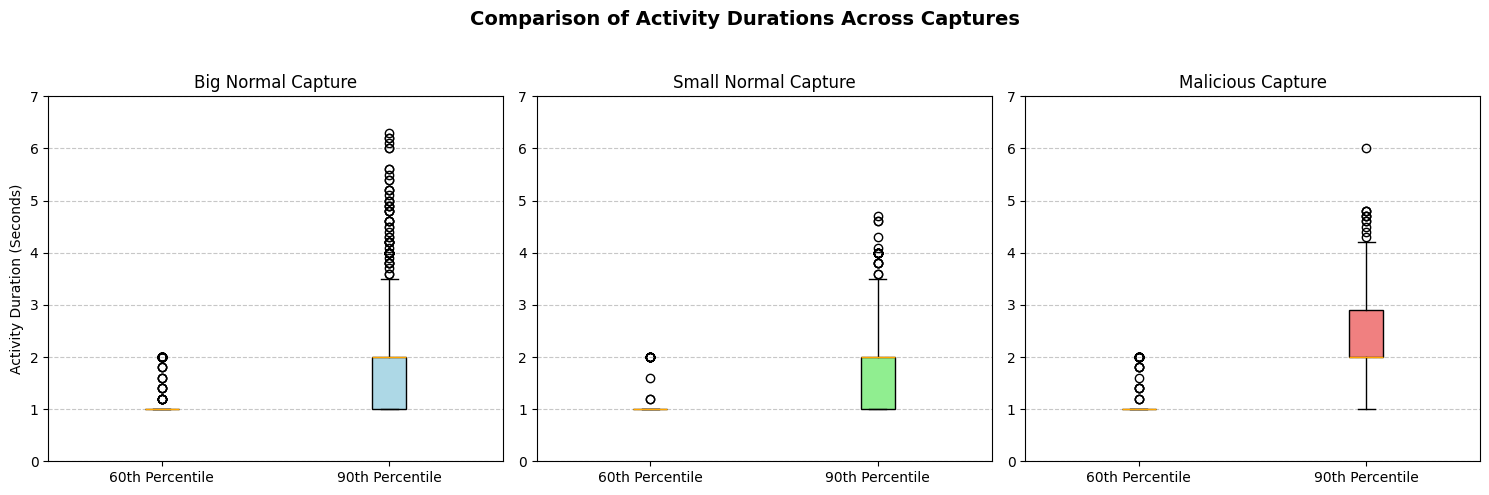

In [23]:
# Create a larger figure for better layout
plt.figure(figsize=(15, 5))

# Define consistent Y-axis range for all boxplots
y_range = [0, 7]  # Adjust this based on your data range

# Plot 1: Big Normal Capture
plt.subplot(1, 3, 1)
plt.boxplot([discord_normal_observation_dataset['60_percentile_activity_duration'],
             discord_normal_observation_dataset['90_percentile_activity_duration']],
            patch_artist=True, 
            boxprops=dict(facecolor="lightblue"), 
            medianprops=dict(color="orange"),
            flierprops=dict(marker='o', color='red', markersize=6))
plt.title('Big Normal Capture', fontsize=12)
plt.xticks([1, 2], ['60th Percentile', '90th Percentile'])
plt.ylim(y_range)
plt.ylabel('Activity Duration (Seconds)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Small Normal Capture
plt.subplot(1, 3, 2)
plt.boxplot([discord_small_normal_observation_dataset['60_percentile_activity_duration'],
             discord_small_normal_observation_dataset['90_percentile_activity_duration']],
            patch_artist=True, 
            boxprops=dict(facecolor="lightgreen"), 
            medianprops=dict(color="orange"),
            flierprops=dict(marker='o', color='red', markersize=6))
plt.title('Small Normal Capture', fontsize=12)
plt.xticks([1, 2], ['60th Percentile', '90th Percentile'])
plt.ylim(y_range)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Malicious Capture
plt.subplot(1, 3, 3)
plt.boxplot([discord_malicious_observation_dataset['60_percentile_activity_duration'],
             discord_malicious_observation_dataset['90_percentile_activity_duration']],
            patch_artist=True, 
            boxprops=dict(facecolor="lightcoral"), 
            medianprops=dict(color="orange"),
            flierprops=dict(marker='o', color='red', markersize=6))
plt.title('Malicious Capture', fontsize=12)
plt.xticks([1, 2], ['60th Percentile', '90th Percentile'])
plt.ylim(y_range)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a main title
plt.suptitle('Comparison of Activity Durations Across Captures', fontsize=14, fontweight='bold')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the improved plot
plt.show()

#### Normalization and Split Process

In [24]:
# Perform normalization of the dataset (MinMaxScaler) - Use the training dataset to fit the scaler
scaler = MinMaxScaler()
scaler.fit(discord_normal_observation_dataset)

normalized_discord_normal_observation_dataset = scaler.transform(discord_normal_observation_dataset)
normalized_discord_normal_small_observation_dataset = scaler.transform(discord_small_normal_observation_dataset)
normalized_discord_malicious_observation_dataset = scaler.transform(discord_malicious_observation_dataset)

# Extract the features from the dataframe
train = normalized_discord_normal_observation_dataset
test = normalized_discord_malicious_observation_dataset
test_good = normalized_discord_normal_small_observation_dataset

##### PCA (Principal Component Analysis)

In [25]:
pca = skd.PCA(n_components=2)
pca.fit(train)
train_pca = pca.transform(train)
test_pca = pca.transform(test)
test_good_pca = pca.transform(test_good)

#### Model Training

- Isolation Forest
- One-Class SVM
- Autoencoder

##### One-Class SVM

In [47]:
# Initialize the OneClassSVM model (Unsupervised learning)
malicious_behavior_percentage = 0.00001
ocsvm = OneClassSVM(kernel='linear', gamma='auto', nu=malicious_behavior_percentage)
ocsvm2 = OneClassSVM(kernel='rbf', nu=malicious_behavior_percentage, gamma=0.5)
ocsvm3 = OneClassSVM(kernel='poly', degree=3, nu=malicious_behavior_percentage)

# Train the model
ocsvm.fit(train_pca)
ocsvm2.fit(train_pca)
ocsvm3.fit(train_pca)

# Test the model
predictions = ocsvm.predict(test_pca)
predictions2 = ocsvm2.predict(test_pca)
predictions3 = ocsvm3.predict(test_pca)

good_predictions = ocsvm.predict(test_good_pca)

##### Evaluation

In [27]:
# Display the number of normal and malicious observations
print("FOR THE MALICIOUS OBSERVATIONS")
print("Normal observations: ", len(predictions[predictions == 1]))
print("Malicious observations: ", len(predictions[predictions == -1]))

# Display the percentage of malicious observations
print(f"Percentage of malicious observations: {len(predictions[predictions == -1]) / len(predictions) * 100:.2f}%")

FOR THE MALICIOUS OBSERVATIONS
Normal observations:  143
Malicious observations:  453
Percentage of malicious observations: 76.01%


In [28]:
print("\n\nFOR THE GOOD OBSERVATIONS")
print("Normal observations: ", len(good_predictions[good_predictions == 1]))
print("Malicious observations: ", len(good_predictions[good_predictions == -1]))

# Display the percentage of malicious observations
print(f"Percentage of malicious observations: {len(good_predictions[good_predictions == -1]) / len(good_predictions) * 100:.2f}%")



FOR THE GOOD OBSERVATIONS
Normal observations:  419
Malicious observations:  91
Percentage of malicious observations: 17.84%


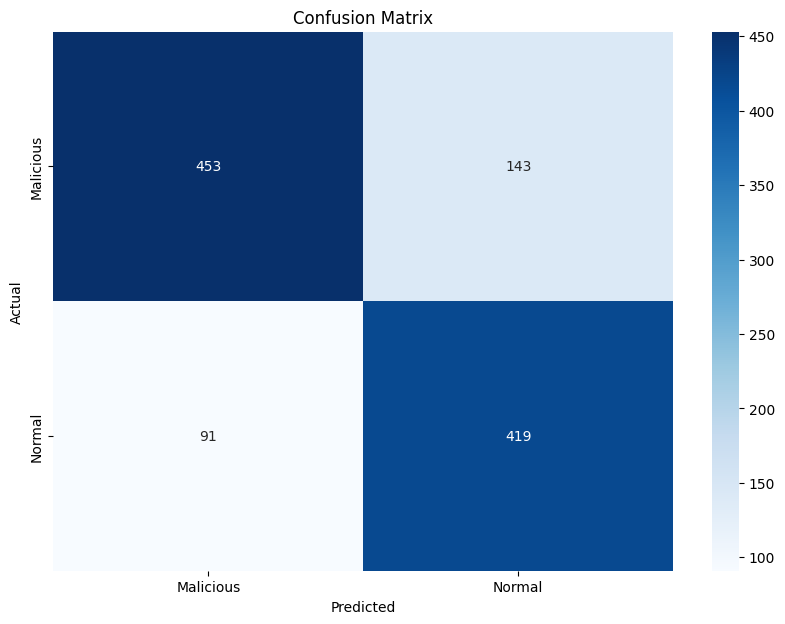

Precision: 0.83
Recall: 0.76
F1 Score: 0.79
Accuracy: 0.79


In [39]:
# Confusion Matrix
true_positives = len(predictions[predictions == -1])
false_negatives = len(predictions[predictions == 1])
false_positives = len(good_predictions[good_predictions == -1])
true_negatives = len(good_predictions[good_predictions == 1])

plt.figure(figsize=(10, 7))
sns.heatmap([[true_positives, false_negatives], [false_positives, true_negatives]], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Malicious', 'Normal'])
plt.yticks([0.5, 1.5], ['Malicious', 'Normal'])
plt.title('Confusion Matrix')
plt.show()

precision = true_positives / (true_positives + false_positives)
print(f"Precision: {precision:.2f}")

recall = true_positives / (true_positives + false_negatives)
print(f"Recall: {recall:.2f}")

f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score:.2f}")

accuracy = (true_positives + true_negatives) / (true_positives + false_negatives + false_positives + true_negatives)
print(f"Accuracy: {accuracy:.2f}")

#### Ensemble Model

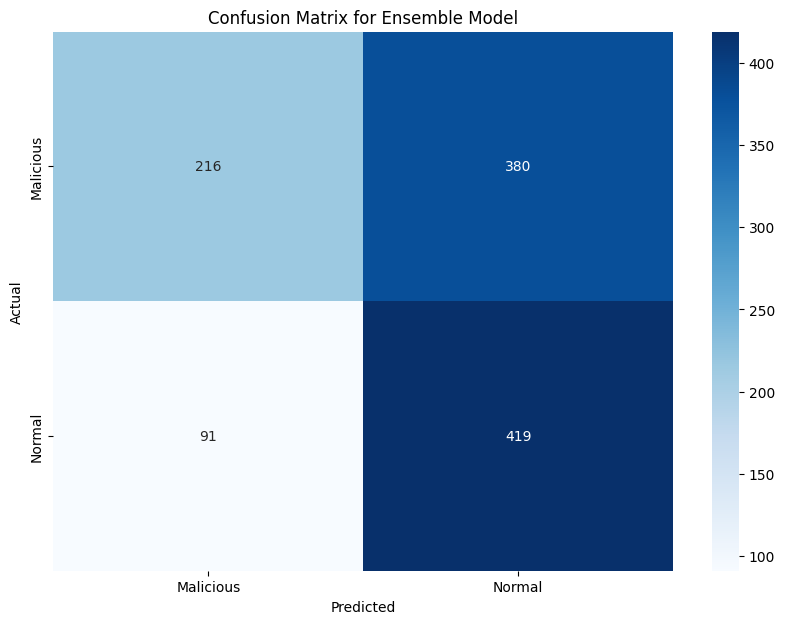

In [30]:
# Combine predictions using majority voting
WEIGHTS = [0.3, 0.3, 0.1]
ensemble_predictions = np.array([predictions, predictions2, predictions3])
mean_prediction = np.average(ensemble_predictions, axis=0, weights=WEIGHTS)
final_predictions = np.where(mean_prediction < 0, -1, 1)

# Make confusion matrix for the ensemble model
true_positives = len(final_predictions[final_predictions == -1])
false_negatives = len(final_predictions[final_predictions == 1])
false_positives = len(good_predictions[good_predictions == -1])
true_negatives = len(good_predictions[good_predictions == 1])

plt.figure(figsize=(10, 7))

sns.heatmap([[true_positives, false_negatives], [false_positives, true_negatives]], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Malicious', 'Normal'])
plt.yticks([0.5, 1.5], ['Malicious', 'Normal'])
plt.title('Confusion Matrix for Ensemble Model')
plt.show()

##### Isolation Forest

In [85]:
# Train Isolation Forest
isolation_forest = IsolationForest(n_estimators=1000, contamination=0.001, random_state=42)
isolation_forest.fit(train_pca)

# Predict anomalies
predictions_good = isolation_forest.predict(test_good_pca)
predictions = isolation_forest.predict(test_pca)

##### Evaluation

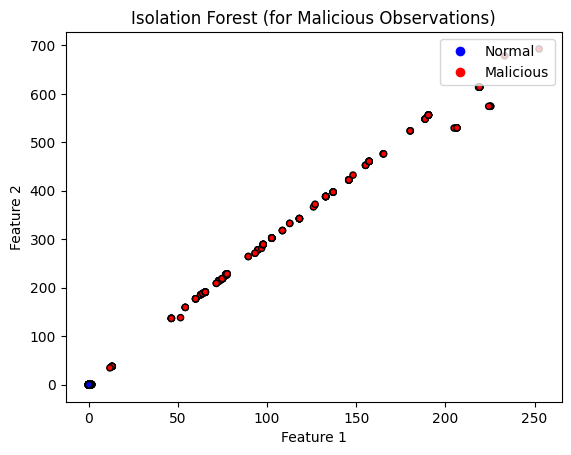

Normal observations:  400
Malicious observations:  196
Percentage of malicious observations: 32.89%


In [82]:
# Assign colors explicitly based on predictions
colors = ['red' if pred == -1 else 'blue' for pred in predictions]  # Red = Malicious (-1), Blue = Normal (1)

# Plot the scatter graph
plt.scatter(test_pca[:, 0], test_pca[:, 1], c=colors, s=20, edgecolor='k')
plt.title('Isolation Forest (for Malicious Observations)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Normal'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Malicious')
], loc='upper right')
plt.show()

# Print observation counts
print("Normal observations: ", len(predictions[predictions == 1]))
print("Malicious observations: ", len(predictions[predictions == -1]))

# Display the percentage of malicious observations
print(f"Percentage of malicious observations: {len(predictions[predictions == -1]) / len(predictions) * 100:.2f}%")

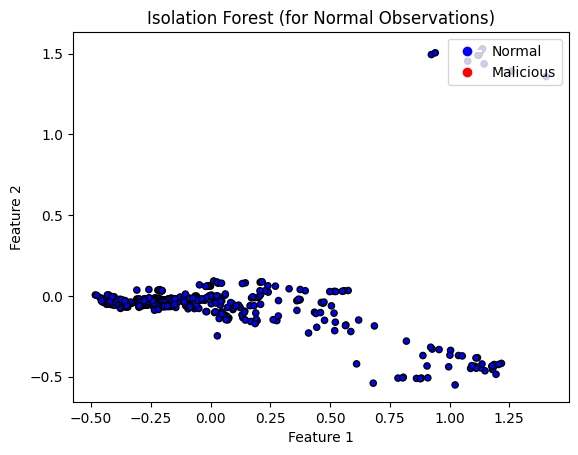

Normal observations:  510
Malicious observations:  0
Percentage of malicious observations: 0.00%


In [83]:
# Assign colors explicitly based on predictions
colors = ['red' if pred == -1 else 'blue' for pred in predictions_good]  # Red = Malicious (-1), Blue = Normal (1)

# Plot the scatter graph
plt.scatter(test_good_pca[:, 0], test_good_pca[:, 1], c=colors, s=20, edgecolor='k')
plt.title('Isolation Forest (for Normal Observations)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Normal'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Malicious')
], loc='upper right')
plt.show()

# Print observation counts
print("Normal observations: ", len(predictions_good[predictions_good == 1]))
print("Malicious observations: ", len(predictions_good[predictions_good == -1]))

# Display the percentage of malicious observations
print(f"Percentage of malicious observations: {len(predictions_good[predictions_good == -1]) / len(predictions_good) * 100:.2f}%")

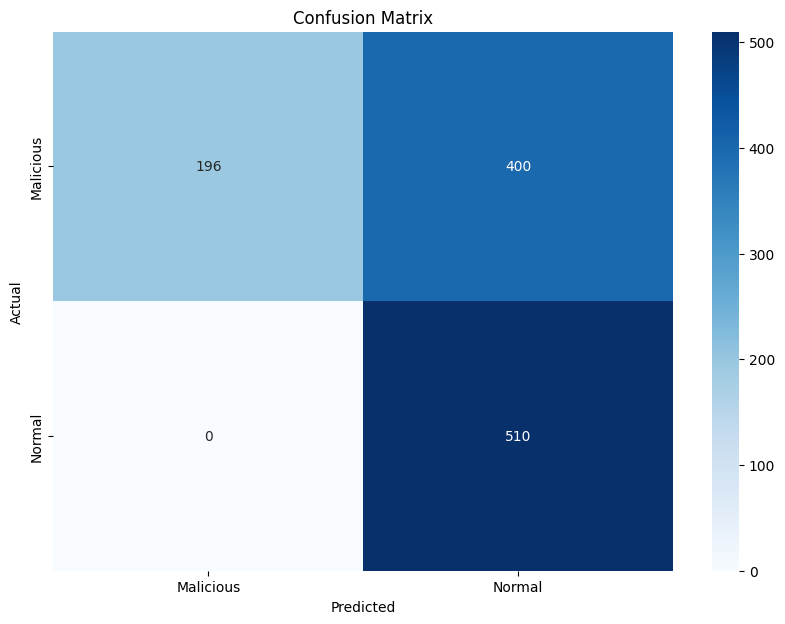

In [84]:
# Confusion matrix for isolation forest
true_positives = len(predictions[predictions == -1])
false_negatives = len(predictions[predictions == 1])
false_positives = len(predictions_good[predictions_good == -1]) 
true_negatives = len(predictions_good[predictions_good == 1])

plt.figure(figsize=(10, 7))
sns.heatmap([[true_positives, false_negatives], [false_positives, true_negatives]], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Malicious', 'Normal'])
plt.yticks([0.5, 1.5], ['Malicious', 'Normal']) 
plt.title('Confusion Matrix')

plt.show()

##### Autoencoder

In [34]:
# Example for tabular data
input_dim = 2  # Number of features
encoding_dim = 12  # Latent space dimension

# Define the encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Define the decoder
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Build the autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model 
autoencoder.fit(train_pca, train_pca, epochs=100, batch_size=32, shuffle=True)
# Predict the anomalies
predictions = autoencoder.predict(test_pca)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4013   
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3769 
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3499 
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3034 
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2661 
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2307 
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2005 
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1784 
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1662 
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1448 
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1269 
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1168 
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1063 
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0981 
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - l

##### Evaluation

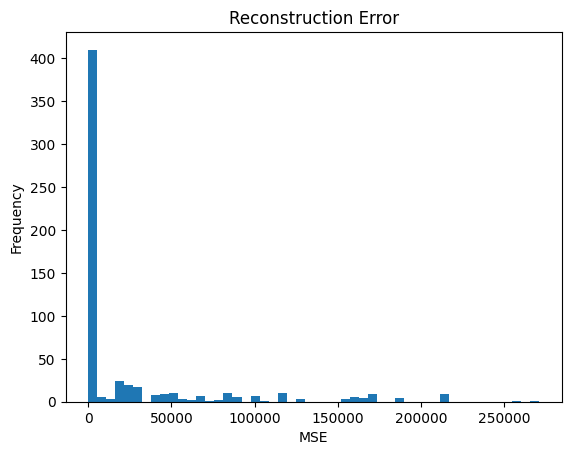

Threshold: 160937.86
Normal observations:  566
Malicious observations:  30
Percentage of malicious observations: 5.03%


In [35]:
# Reconstruction error (MSE) for each observation
mse = np.mean(np.power(test_pca - predictions, 2), axis=1)

# Display the MSE values graphically
plt.hist(mse, bins=50)
plt.title('Reconstruction Error')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()

# Calculate the threshold
threshold = np.percentile(mse, 95) # 95th percentile
print(f"Threshold: {threshold:.2f}")

# Predict the anomalies
anomalies = (mse >= threshold).astype(int)

# Display the number of normal and malicious observations
print("Normal observations: ", len(anomalies[anomalies == 0]))
print("Malicious observations: ", len(anomalies[anomalies == 1]))

# Display the percentage of malicious observations
print(f"Percentage of malicious observations: {len(anomalies[anomalies == 1]) / len(anomalies) * 100:.2f}%")